look at changes in returns before and after ESG changes.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import invgamma
import datetime
import scipy
import importlib
import os, sys
sys.path.insert(0, 'C:/Users/User/Code/MMDGraph')
import seaborn as sns
import pandas as pd
import MMDforGraphs as mg
import statsmodels.api as sm

Read ESG data

In [3]:
PRICE = pd.read_csv("../Yahoo/YAHOO_PRICE.csv")
ESG_data = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'ESG')
TICKERS = np.unique(ESG_data['ticker'])
companies = np.unique(PRICE['ticker']) 


esg_series = ESG_data.copy()  #ESG_data.loc[ESG_data['ticker'] == 'BMY'].copy()
esg_series['timestamp'] = pd.to_datetime(esg_series['timestamp'])
min_date = datetime.datetime(2014,10, 1)
max_date = np.max(ESG_data['timestamp'])
esg_series['date'] = esg_series['timestamp'].dt.date
print(min_date)
print(max_date)
esg_series


# Create a series of days, which will then be joined with esg_series, To create "daily" ESG.
dates = pd.DataFrame({'date':pd.date_range(min_date,max_date,freq='d')})
dates['date'] = dates['date'].dt.date

# create an esg data frame where index is monthly
esg_pivot = esg_series[['ticker', 'esgScore', 'date']].copy()
esg_pivot_diff = pd.pivot_table(esg_pivot, values = 'esgScore', index = 'date', columns= 'ticker').diff()#.iloc[1:]
esg_pivot = pd.pivot_table(esg_pivot, values = 'esgScore', index = 'date', columns= 'ticker')
esg_pivot = pd.merge(dates, esg_pivot, how = 'left', left_on='date', right_index=True)
esg_pivot_diff = pd.merge(dates, esg_pivot_diff, how = 'left', left_on='date', right_index=True)
esg_pivot.set_index('date', inplace= True)
esg_pivot_diff.set_index('date', inplace= True)
#esg_pivot = esg_pivot.loc[esg_pivot.index <= datetime.date(2019, 11, 1)]

asset_profiles = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 

esg_pivot_enough_data = esg_pivot.loc[:,~np.isnan(esg_pivot.iloc[0,:])]
sector_classification = dict()
for company in esg_pivot_enough_data.columns:
    sector_of_company = asset_profiles['sector'].loc[asset_profiles['ticker'] == company].iloc[0]
    if sector_of_company not in sector_classification.keys():
        sector_classification[sector_of_company] = list()
    sector_classification[sector_of_company].append(company)

esg_pivot



2014-10-01 00:00:00
2022-02-01 00:00:00


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-10-01,71.00,73.00,48.00,60.00,62.00,55.00,64.00,72.00,70.00,64.00,...,77.00,50.0,71.0,65.00,57.00,64.00,58.00,61.00,47.0,47.00
2014-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Read Price

In [93]:
asset_profiles = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 
price_data = pd.read_csv("../Yahoo/YAHOO_PRICE.csv")

price_data['timestamp'] = pd.to_datetime(price_data['timestamp'])
price_filtered = price_data.loc[price_data['timestamp'] > datetime.datetime(2014,9, 1), price_data.columns]
price_filtered['date'] = price_filtered['timestamp'].dt.date

price_filtered['return'] = price_filtered.sort_values('date').groupby(['ticker']).adjclose.pct_change()


price_pivot = price_filtered[['ticker', 'return', 'date']].copy()
price_pivot['return'] = np.log(1 + price_pivot['return'])
price_pivot = price_pivot.dropna()  # Drop rows which contain missing values
price_pivot = pd.pivot_table(price_pivot, values = 'return', index = 'date', columns= 'ticker')
price_pivot.shape

# Let's order the columns by sector
company_df = pd.DataFrame({'ticker': np.array(price_pivot.columns)})
company_df = pd.merge(company_df, asset_profiles, on='ticker', how = 'left')
company_df['track_index'] = np.array(range(company_df.shape[0]))
company_df = company_df.sort_values(by = 'sector')
price_pivot = price_pivot.iloc[:, company_df['track_index']]

Get market index

In [94]:
def get_index(tick):
    """
    Function that takes the sp500 index from yahoo
    """
    import requests
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    # ESG historical data (only changes yearly)
    url_esg = f"https://query1.finance.yahoo.com/v7/finance/spark?symbols={tick}&range=10y&interval=1d&indicators=close&includeTimestamps=false&includePrePost=false&corsDomain=finance.yahoo.com&.tsrc=finance"
    response = requests.get(url_esg, headers=headers)
    if response.ok:
        sp500 = pd.DataFrame({'date':pd.to_datetime(response.json()['spark']['result'][0]['response'][0]['timestamp'], unit= 's'),
                              'price':response.json()['spark']['result'][0]['response'][0]['indicators']['quote'][0]['close']})
    
    else:
        print("Empty data frame")
        sp500 = pd.DataFrame()



    return sp500

In [95]:
sp500 = get_index('^GSPC')
sp500['date'] = pd.to_datetime(sp500['date']).dt.date
sp500['return'] = 1 + sp500['price'].pct_change()
sp500['log_return'] = np.log(sp500['price']).diff()
sp500 = sp500.iloc[:,:].dropna(axis= 0)
sp500 = sp500.set_index('date')

# Perform on Single asset

In [6]:
stock  = 'AAPL'
y_esg = esg_pivot_diff[stock]
y = price_pivot[stock]
x = sp500['log_return']

data = pd.merge(y_esg, y, left_index = True, right_index = True, how = 'left')
data = pd.merge(data, sp500.loc[:, 'log_return'], left_index = True, right_index = True, how = 'left')
data.head(20)


,AAPL_x,AAPL_y,log_return
date,,,
2014-10-01,-1.0,-0.015706,-0.013337
2014-10-02,NaN,0.007233,0.000005
2014-10-03,NaN,-0.002807,0.011104
2014-10-04,NaN,NaN,NaN
2014-10-05,NaN,NaN,NaN
2014-10-06,NaN,0.000000,-0.001566
2014-10-07,NaN,-0.008772,-0.015242
2014-10-08,NaN,0.020547,0.017311
2014-10-09,NaN,0.002180,-0.020878


Green is where esg decreases and red is where increase

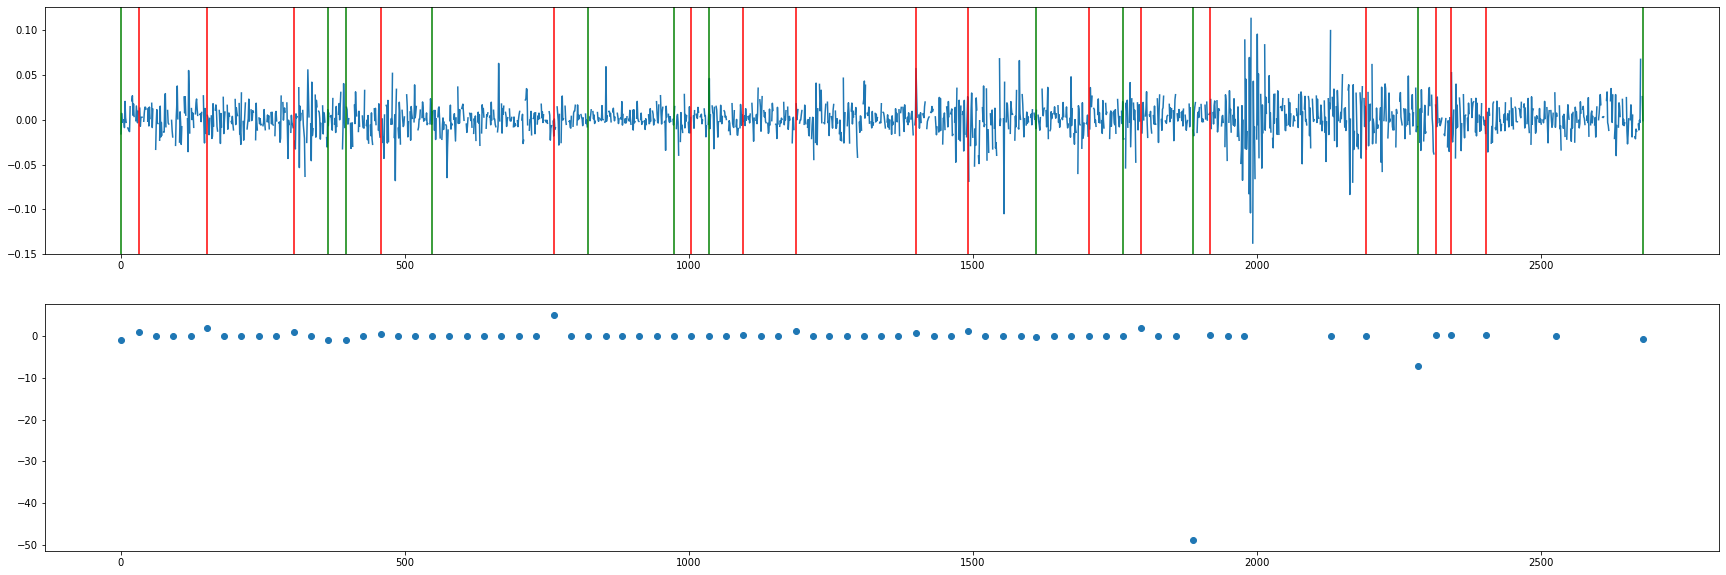

In [7]:
fix, ax = plt.subplots(2,1, figsize = (30,10))
ax[0].plot(range(data.shape[0]), data['AAPL_y'])
for i, esg in enumerate(data['AAPL_x']):
    if esg != 0 and ~np.isnan(esg):
        if(esg <0):
            ax[0].axvline(i, color = 'green')
        else:
            ax[0].axvline(i, color = 'red')

ax[1].scatter(range(data.shape[0]), data['AAPL_x'])


In [8]:
from arch import arch_model

y = price_pivot[stock].loc[(price_pivot.index >= np.min(esg_pivot.index)) & (price_pivot.index <= np.max(esg_pivot.index))]
x = sp500['log_return'].loc[(sp500.index >= np.min(esg_pivot.index)) & (sp500.index <= np.max(esg_pivot.index))]

am = arch_model(100*y, 100*x, mean='LS', p=1, q=1, dist="StudentsT")
from scipy import stats
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
res = am.fit()
print(acorr_ljungbox(res.resid / res.conditional_volatility, lags = [1]))

Iteration:      1,   Func. Count:      8,   Neg. LLF: 50897.63803669828
Iteration:      2,   Func. Count:     18,   Neg. LLF: 29986.780146794837
Iteration:      3,   Func. Count:     27,   Neg. LLF: 9028.054957215165
Iteration:      4,   Func. Count:     36,   Neg. LLF: 6233.19798940143
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4206.769789119695
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4266.676745513982
Iteration:      7,   Func. Count:     61,   Neg. LLF: 2799.8512296347217
Iteration:      8,   Func. Count:     69,   Neg. LLF: 2795.5045314538747
Iteration:      9,   Func. Count:     77,   Neg. LLF: 2793.1474625101473
Iteration:     10,   Func. Count:     85,   Neg. LLF: 2790.446573276722
Iteration:     11,   Func. Count:     93,   Neg. LLF: 2790.378418923635
Iteration:     12,   Func. Count:    101,   Neg. LLF: 2790.310432650611
Iteration:     13,   Func. Count:    108,   Neg. LLF: 2790.3094777586093
Iteration:     14,   Func. Count:    115,   Neg. LLF: 2790.3

C:\Users\User\AppData\Local\Temp\ipykernel_16312\1917998877.py:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pd.concat([std_resid, unit_var_resid], 1)


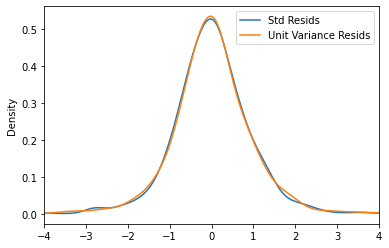

In [9]:
std_resid = res.resid / res.conditional_volatility
unit_var_resid = res.resid / res.resid.std()
df = pd.concat([std_resid, unit_var_resid], 1)
df.columns = ["Std Resids", "Unit Variance Resids"]
subplot = df.plot(kind="kde", xlim=(-4, 4))

In [10]:
y_clean = pd.DataFrame({'y_clean':res.resid/res.conditional_volatility}, index = y.index)
y_clean[y_clean > 2] = 2
y_clean[y_clean < -2] = -2

In [11]:
data = pd.merge(data, y_clean, left_index = True, right_index = True, how = 'left')
data.head(20)

,AAPL_x,AAPL_y,log_return,y_clean
date,,,,
2014-10-01,-1.0,-0.015706,-0.013337,-0.034063
2014-10-02,NaN,0.007233,0.000005,0.687766
2014-10-03,NaN,-0.002807,0.011104,-1.635809
2014-10-04,NaN,NaN,NaN,NaN
2014-10-05,NaN,NaN,NaN,NaN
2014-10-06,NaN,0.000000,-0.001566,0.136681
2014-10-07,NaN,-0.008772,-0.015242,0.840606
2014-10-08,NaN,0.020547,0.017311,-0.022543
2014-10-09,NaN,0.002180,-0.020878,2.000000


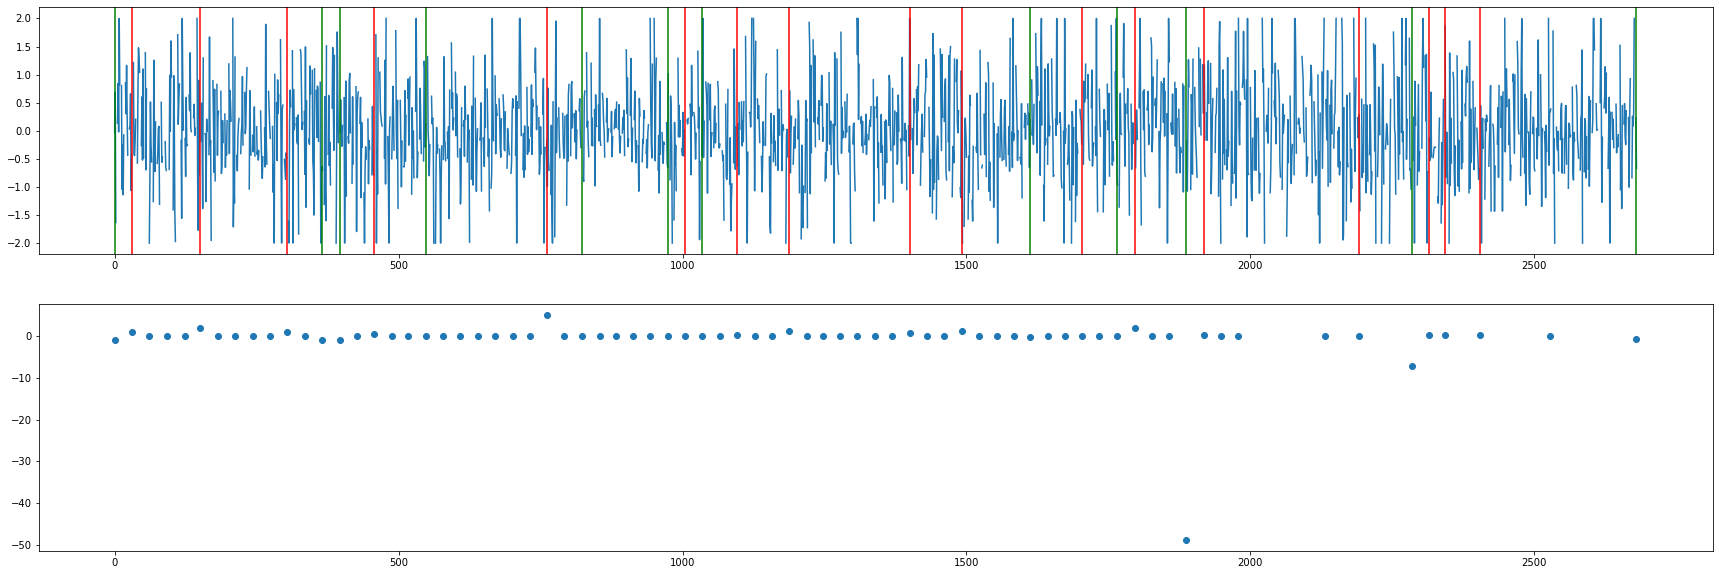

In [12]:
fix, ax = plt.subplots(2,1, figsize = (30,10))
ax[0].plot(range(data.shape[0]), data['y_clean'])
for i, esg in enumerate(data['AAPL_x']):
    if esg != 0 and ~np.isnan(esg):
        if(esg <0):
            ax[0].axvline(i, color = 'green')
        else:
            ax[0].axvline(i, color = 'red')

ax[1].scatter(range(data.shape[0]), data['AAPL_x'])


Let's check 30 days before and after each line. We also take the truncate returns to -0.002 and 0.002.



In [13]:
importlib.reload(sys.modules['MMDforGraphs'])

esg_changes = []
for i, esg in enumerate(data['AAPL_x']):
    if esg != 0 and ~np.isnan(esg):
        if(esg <0):
            ax[0].axvline(i, color = 'green')
        else:
            ax[0].axvline(i, color = 'red')
        esg_changes.append(data.index[i])
        #base = data.index[i]

        #print(date_list = [base - datetime.timedelta(days=x) for x in range(30)])


# Take 30 days before and after
for i in range(1, len(esg_changes)-1):
    base = esg_changes[i]
    last_base = esg_changes[i-1]
    next_base = esg_changes[i+1]
    date_list_before = [base - datetime.timedelta(days=x) for x in range(1,31)]
    y_before = y[np.isin(y.index, date_list_before) & (y.index >=last_base)]
    date_list_after = [base + datetime.timedelta(days=x) for x in range(30)]
    y_after = y[np.isin(y.index, date_list_after) & (y.index < next_base)]

    # number of samples
    n_1 = len(y_before)
    n_2 = len(y_after)

    from sklearn.metrics.pairwise import euclidean_distances

    Z = np.expand_dims(np.r_[y_before, y_after], axis=1)
    D2 = euclidean_distances(Z, squared=True)
    upper = D2[np.triu_indices_from(D2, k=1)]
    kernel_width = np.median(upper, overwrite_input=True)
    bandwidth = np.sqrt(kernel_width / 2)
    kernel_width = 2 * bandwidth**2

    K = np.exp(-D2 * (1/kernel_width))

    print("------ new -------")
    # Wild bootstrap
    mmd_b_p, test, statistic_sample = mg.WildBootstrap(K, 10,n_1 , n_2, 1000)  
    # print(statistic_sample)
    print(f' Wild bootstrap: {mmd_b_p}, iteration {i}')


    MMD_functions = [mg.MMD_b, mg.MMD_u]
    function_arguments=[dict(n = n_1, m = n_2 ), dict(n = n_1, m = n_2 )]
    kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
    kernel_hypothesis.Bootstrap(K, function_arguments, B = 1000, method = 'NBB', boot_arg = {'n':n_1, 'm':n_2, 'l':3} )
    print(f'p_value Block {kernel_hypothesis.p_values}')
    kernel_hypothesis.Bootstrap(K, function_arguments, B = 1000 )
    print(f'p_value  {kernel_hypothesis.p_values}')

    

    

------ new -------
 Wild bootstrap: 0.135, iteration 1
p_value Block {'MMD_b': 0.545, 'MMD_u': 0.465}
p_value  {'MMD_b': 0.483, 'MMD_u': 0.384}
------ new -------
 Wild bootstrap: 0.073, iteration 2
p_value Block {'MMD_b': 0.486, 'MMD_u': 0.468}
p_value  {'MMD_b': 0.56, 'MMD_u': 0.544}
------ new -------
 Wild bootstrap: 0.093, iteration 3
p_value Block {'MMD_b': 0.451, 'MMD_u': 0.523}
p_value  {'MMD_b': 0.366, 'MMD_u': 0.417}
------ new -------
 Wild bootstrap: 0.103, iteration 4
p_value Block {'MMD_b': 0.458, 'MMD_u': 0.487}
p_value  {'MMD_b': 0.413, 'MMD_u': 0.449}
------ new -------
 Wild bootstrap: 0.458, iteration 5
p_value Block {'MMD_b': 0.927, 'MMD_u': 0.9}
p_value  {'MMD_b': 0.931, 'MMD_u': 0.91}
------ new -------
 Wild bootstrap: 0.011, iteration 6
p_value Block {'MMD_b': 0.111, 'MMD_u': 0.163}
p_value  {'MMD_b': 0.237, 'MMD_u': 0.301}
------ new -------
 Wild bootstrap: 0.032, iteration 7
p_value Block {'MMD_b': 0.335, 'MMD_u': 0.335}
p_value  {'MMD_b': 0.156, 'MMD_u': 0.1

In [14]:
n_2

20

# Test all companies

In [96]:
def mmd_test(y_before, y_after, ln = 1, block_length = 3):
    """
    Wild bootstrap
    Block bootstrap
    Permutation bootstrap
    
    """
    # number of samples
    n_1 = len(y_before)
    n_2 = len(y_after)

    from sklearn.metrics.pairwise import euclidean_distances

    Z = np.expand_dims(np.r_[y_before, y_after], axis=1)
    D2 = euclidean_distances(Z, squared=True)
    upper = D2[np.triu_indices_from(D2, k=1)]
    kernel_width = np.median(upper, overwrite_input=True)
    bandwidth = np.sqrt(kernel_width / 2)
    kernel_width = 2 * bandwidth**2

    K = np.exp(-D2 * (1/kernel_width))

    #print("------ new -------")
    # Wild bootstrap
    wild_p_val, test, statistic_sample = mg.WildBootstrap(K, ln, n_1 , n_2, 1000)  
    # print(statistic_sample)
    #print(f' Wild bootstrap: {mmd_b_p}, iteration {i}')


    MMD_functions = [mg.MMD_b, mg.MMD_u]
    function_arguments=[dict(n = n_1, m = n_2 ), dict(n = n_1, m = n_2 )]
    kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
    kernel_hypothesis.Bootstrap(K, function_arguments, B = 1000, method = 'NBB', boot_arg = {'n':n_1, 'm':n_2, 'l':block_length} )
    #print(f'p_value Block {kernel_hypothesis.p_values}')
    block_p_val = kernel_hypothesis.p_values['MMD_u']
    kernel_hypothesis.Bootstrap(K, function_arguments, B = 1000 )
    #print(f'p_value  {kernel_hypothesis.p_values}')
    p_val = kernel_hypothesis.p_values['MMD_u']

    return wild_p_val, block_p_val, p_val

In [6]:
df = pd.read_pickle(f'../data/ESG_uni/run_09052022.pkl')
df

,Std Resids,Unit Variance Resids,stock,sector,date,direction_up,n_before,n_after,mmd_wild_raw,mmd_block_raw,mmd_perm_raw,mmd_wild_median,mmd_block_median,mmd_perm_median,mmd_wild_garch,mmd_block_garch,mmd_perm_garch
0,-0.034063,-0.028295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.687766,0.557501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1.635809,-1.322969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.136681,0.120064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.840606,0.718094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10005,NaN,NaN,VZ,Communication Services,2019-10-01,1.0,20.0,22.0,0.316,0.349,0.388,0.205,0.219,0.277,0.200,0.228,0.264
10006,NaN,NaN,VZ,Communication Services,2019-12-01,0.0,20.0,20.0,0.847,0.914,0.906,0.877,0.959,0.921,0.895,0.979,0.954
10007,NaN,NaN,VZ,Communication Services,2020-08-01,1.0,21.0,20.0,0.564,0.693,0.646,0.337,0.455,0.395,0.390,0.514,0.445
10008,NaN,NaN,VZ,Communication Services,2020-10-01,0.0,21.0,22.0,0.752,0.802,0.807,0.378,0.566,0.403,0.379,0.549,0.407


In [11]:
np.isin(stock, df['stock'])

array(True)

In [97]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model
import pickle
import tqdm
df = pd.DataFrame()
pbar = tqdm.tqdm(total= np.sum([len(v) for k, v in sector_classification.items() ]))

for k, v in sector_classification.items():

    for stock in v:

        if ~np.isin(stock, esg_pivot_diff.columns):
            pbar.update()
            print(f"{stock} skipped")
            continue

        y_esg = esg_pivot_diff[stock]
        y = price_pivot[stock]
        x = sp500['log_return']

        y = pd.merge(y,x, left_index=True, right_index=True)
        y = y.dropna()

        data = pd.merge(y_esg, y, left_index = True, right_index = True, how = 'left')

        tmp = pd.DataFrame({'stock':stock, 'sector':k}, index = [0])


        # Fit median
        covariates = pd.DataFrame({'market': y.loc[:,'log_return']})
        covariates['const'] = 1
        model_robust = sm.QuantReg(y[stock], covariates)
        results_robust = model_robust.fit(q = 0.5, max_iter = 10000)
        y_hat_rob = model_robust.predict(results_robust.params)
        #tmp['autocorrelation_median'] = acorr_ljungbox(y_hat_rob, lags = [1]).iloc[0,1]
        y_hat_rob = pd.DataFrame({'y_median':y_hat_rob - y.loc[:,stock]}, index = y.index)

        # Garch volatilities
        am = arch_model(100*y[stock], 100*y['log_return'], mean='LS', p=1, q=1, dist="StudentsT")
        res = am.fit(disp = 'off')
        #tmp['autocorrelation_garch'] = acorr_ljungbox(res.resid / res.conditional_volatility, lags = [1]).iloc[0,1]
        y_garch = pd.DataFrame({'y_garch':res.resid / res.conditional_volatility}, index = y.index)

        # Check esg changes
        esg_changes = []
        esg_changes_numeric = []
        for i, esg in enumerate(data[stock + "_x"]):
            if esg != 0 and ~np.isnan(esg):
                esg_changes.append(data.index[i])
                esg_changes_numeric.append(esg)

            # For all ESG changes, check before and after

        for i in range(1, len(esg_changes)-1):

            tmp = pd.DataFrame({'stock':stock, 'sector':k}, index = [0])

            base = esg_changes[i]
            tmp['date'] = base
            last_base = esg_changes[i-1]
            next_base = esg_changes[i+1]
            date_list_before = [base - datetime.timedelta(days=x) for x in range(1,31)]
            date_list_after = [base + datetime.timedelta(days=x) for x in range(30)]
            tmp['direction_up'] = (esg_changes_numeric[i] > 0)*1

            y_before = np.array(y[stock].loc[np.isin(y.index, date_list_before) & (y.index >=last_base)])
            y_after = np.array(y[stock].loc[np.isin(y.index, date_list_after) & (y.index < next_base)])

            tmp['n_before'] = len(y_before)
            tmp['n_after'] = len(y_after)

            if len(y_before) == 0 or len(y_after) == 0:
                continue


            wild_p_val, block_p_val, p_val = mmd_test(y_before, y_after, ln = 1)
            tmp['mmd_wild_raw'] = wild_p_val
            tmp['mmd_block_raw'] = block_p_val
            tmp['mmd_perm_raw'] = p_val

            y_before = np.array(y_hat_rob['y_median'].loc[np.isin(y.index, date_list_before) & (y.index >=last_base)])
            y_after = np.array(y_hat_rob['y_median'].loc[np.isin(y.index, date_list_after) & (y.index < next_base)])

            wild_p_val, block_p_val, p_val = mmd_test(y_before, y_after, ln = 1)
            tmp['mmd_wild_median'] = wild_p_val
            tmp['mmd_block_median'] = block_p_val
            tmp['mmd_perm_median'] = p_val

            y_before = np.array(y_garch['y_garch'].loc[np.isin(y.index, date_list_before) & (y.index >=last_base)])
            y_after = np.array(y_garch['y_garch'].loc[np.isin(y.index, date_list_after) & (y.index < next_base)])

            wild_p_val, block_p_val, p_val = mmd_test(y_before, y_after, ln = 1)
            tmp['mmd_wild_garch'] = wild_p_val
            tmp['mmd_block_garch'] = block_p_val
            tmp['mmd_perm_garch'] = p_val

            df = pd.concat((df, tmp), ignore_index=True)


        with open('../data/ESG_uni/run_09052022.pkl', 'wb') as f:
            pickle.dump(df, f)

        pbar.update()

pbar.close()


        



  2%|▏         | 9/413 [02:44<2:00:36, 17.91s/it]c:\Users\User\Code\MMDGraph\.mmdvenv\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
100%|██████████| 413/413 [1:37:36<00:00, 14.18s/it]


In [19]:
pbar.close()

In [7]:
rejection_alpha = 0.05
for col in ['mmd_wild_raw',	'mmd_block_raw',	'mmd_perm_raw',
                'mmd_wild_median',	'mmd_block_median',	'mmd_perm_median',	
                'mmd_wild_garch',	'mmd_block_garch',	'mmd_perm_garch']:

    df[col + '_r'] = (df[col] < rejection_alpha)*1

Fraction of rejections for each sector:

In [8]:
df[['sector', 'mmd_wild_raw_r',	'mmd_block_raw_r',	'mmd_perm_raw_r',
                'mmd_wild_median_r',	'mmd_block_median_r',	'mmd_perm_median_r',	
                'mmd_wild_garch_r',	'mmd_block_garch_r',	'mmd_perm_garch_r']].groupby(['sector'], as_index=False).agg(['mean'])#sum()

,mmd_wild_raw_r,mmd_block_raw_r,mmd_perm_raw_r,mmd_wild_median_r,mmd_block_median_r,mmd_perm_median_r,mmd_wild_garch_r,mmd_block_garch_r,mmd_perm_garch_r
,mean,mean,mean,mean,mean,mean,mean,mean,mean
sector,,,,,,,,,
Basic Materials,0.090452,0.060302,0.072864,0.100503,0.062814,0.082915,0.070352,0.050251,0.057789
Communication Services,0.061350,0.058282,0.042945,0.095092,0.064417,0.064417,0.082822,0.061350,0.039877
Consumer Cyclical,0.115686,0.084314,0.090196,0.103922,0.075490,0.086275,0.084314,0.053922,0.065686
Consumer Defensive,0.101648,0.071429,0.071429,0.108516,0.070055,0.075549,0.085165,0.054945,0.054945
Energy,0.085399,0.055096,0.066116,0.101928,0.068871,0.060606,0.066116,0.044077,0.038567
Financial Services,0.115458,0.087786,0.088740,0.109733,0.081107,0.088740,0.093511,0.066794,0.073473
Healthcare,0.126394,0.092937,0.095725,0.109665,0.076208,0.080855,0.094796,0.063197,0.063197
Industrials,0.115942,0.081841,0.090367,0.117647,0.083546,0.085251,0.102302,0.063939,0.068201


Fraction of rejection per sector and per ESG change direction:

In [54]:
df[['sector','direction_up', 'mmd_wild_raw_r',	'mmd_block_raw_r',	'mmd_perm_raw_r',
                'mmd_wild_median_r',	'mmd_block_median_r',	'mmd_perm_median_r',	
                'mmd_wild_garch_r',	'mmd_block_garch_r',	'mmd_perm_garch_r']].groupby(['sector', 'direction_up'], as_index=False).agg(['mean'])#sum()

mmd_wild_raw_r mmd_block_raw_r  \
                                              mean            mean   
sector                 direction_up                                  
Basic Materials        0.0                0.093023        0.055814   
                       1.0                0.087432        0.065574   
Communication Services 0.0                0.051282        0.044872   
                       1.0                0.070588        0.070588   
Consumer Cyclical      0.0                0.115646        0.076531   
                       1.0                0.115741        0.094907   
Consumer Defensive     0.0                0.097130        0.066225   
                       1.0                0.109091        0.080000   
Energy                 0.0                0.098958        0.067708   
                       1.0                0.070175        0.040936   
Financial Services     0.0                0.116638        0.082333   
                       1.0                0.113978        0.094624   
Healthcare             0.0                0.129485        0.082683   
                       1.0                0.121839        0.108046   
Industrials            0.0                0.096454        0.072340   
                       1.0                0.145299        0.096154   
Real Estate            0.0                0.065306        0.040816   
                       1.0                0.065217        0.059783   
Technology             0.0                0.096339        0.069364   
                       1.0                0.135307        0.101480   
Utilities              0.0                0.120370        0.077160   
                       1.0                0.084211        0.063158   

                                    mmd_perm_raw_r mmd_wild_median_r  \
                                              mean              mean   
sector                 direction_up                                    
Basic Materials        0.0                0.069767          0.097674   
                       1.0                0.076503          0.103825   
Communication Services 0.0                0.038462          0.108974   
                       1.0                0.047059          0.082353   
Consumer Cyclical      0.0                0.090136          0.122449   
                       1.0                0.090278          0.078704   
Consumer Defensive     0.0                0.068433          0.114790   
                       1.0                0.076364          0.098182   
Energy                 0.0                0.078125          0.114583   
                       1.0                0.052632          0.087719   
Financial Services     0.0                0.092624          0.097770   
                       1.0                0.083871          0.124731   
Healthcare             0.0                0.092044          0.113885   
                       1.0                0.101149          0.103448   
Industrials            0.0                0.072340          0.117730   
                       1.0                0.117521          0.117521   
Real Estate            0.0                0.048980          0.061224   
                       1.0                0.048913          0.070652   
Technology             0.0                0.078998          0.107900   
                       1.0                0.114165          0.107822   
Utilities              0.0                0.086420          0.114198   
                       1.0                0.063158          0.084211   

                                    mmd_block_median_r mmd_perm_median_r  \
                                                  mean              mean   
sector                 direction_up                                        
Basic Materials        0.0                    0.069767          0.074419   
                       1.0                    0.054645          0.092896   
Communication Services 0.0                    0.083333          0.064103   
                       1.0  

Combine p-values

In [15]:
def combine_pvalues_r(x, method):
    return combine_pvalues(x, method)[1]



In [92]:
from scipy.stats import combine_pvalues

comb_p_val_df = pd.DataFrame()

for sector in df['sector'].unique():
    if sector == np.nan:
        continue
    tmp_df = dict()
    tmp_df['sector'] = sector
    for j in ['mmd_wild_raw',	'mmd_block_raw',	'mmd_perm_raw','mmd_wild_median',	'mmd_block_median',	'mmd_perm_median',	'mmd_wild_garch',	'mmd_block_garch',	'mmd_perm_garch']:

        tmp_df[j] = combine_pvalues(df[j].loc[df['sector']==sector], method = 'fisher')[1]

    comb_p_val_df = pd.concat((comb_p_val_df, pd.DataFrame(tmp_df, index= [0])))


comb_p_val_df


c:\Users\User\Code\MMDGraph\.mmdvenv\lib\site-packages\scipy\stats\stats.py:8203: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * np.sum(np.log(pvalues))
c:\Users\User\Code\MMDGraph\.mmdvenv\lib\site-packages\scipy\stats\stats.py:8203: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * np.sum(np.log(pvalues))
c:\Users\User\Code\MMDGraph\.mmdvenv\lib\site-packages\scipy\stats\stats.py:8203: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * np.sum(np.log(pvalues))
c:\Users\User\Code\MMDGraph\.mmdvenv\lib\site-packages\scipy\stats\stats.py:8203: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * np.sum(np.log(pvalues))
c:\Users\User\Code\MMDGraph\.mmdvenv\lib\site-packages\scipy\stats\stats.py:8203: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * np.sum(np.log(pvalues))
c:\Users\User\Code\MMDGraph\.mmdvenv\lib\site-packages\scipy\stats\stats.py:8203: RuntimeWarning: divide by zero encountered 

,sector,mmd_wild_raw,mmd_block_raw,mmd_perm_raw,mmd_wild_median,mmd_block_median,mmd_perm_median,mmd_wild_garch,mmd_block_garch,mmd_perm_garch
0,Healthcare,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.205138,0.045583
0,Industrials,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
0,Consumer Cyclical,0.0,3.585818e-07,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.021985,0.004920
0,Technology,0.0,0.000000e+00,0.0,0.0,9.334081e-09,0.000000,0.000000e+00,0.000000,0.000888
0,Consumer Defensive,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,1.109169e-07,0.413941,0.400908
0,Utilities,0.0,0.000000e+00,0.0,0.0,7.017412e-03,0.000000,0.000000e+00,0.921089,0.000000
0,Financial Services,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
0,Basic Materials,0.0,0.000000e+00,0.0,0.0,1.913505e-02,0.001865,8.529641e-04,0.646691,0.561160
0,Real Estate,0.0,3.780795e-01,0.0,0.0,6.105171e-01,0.092940,1.549380e-03,0.897182,0.558729
0,Energy,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.742940,0.636988


In [28]:
combine_pvalues(df['mmd_block_raw'].loc[df['sector']=='Basic Materials'], method = 'stouffer')

(nan, nan)

(array([15.,  5.,  8., 11.,  7.,  9.,  4., 11.,  3.,  7., 10., 15.,  9.,
         8., 12., 11., 10., 10.,  8.,  9.,  7.,  2.,  7.,  5., 10.,  7.,
         4.,  8., 11.,  9.,  8.,  8.,  8.,  7.,  8.,  8.,  6.,  4.,  6.,
         4., 14.,  6.,  6.,  6.,  6.,  9.,  5.,  9., 12.,  6.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

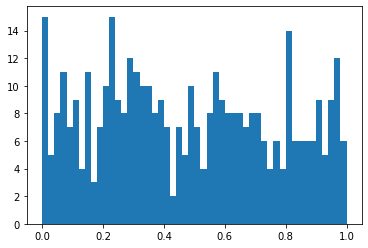

In [32]:
plt.hist(df['mmd_block_raw'].loc[df['sector']=='Basic Materials'], bins = 50)

In [27]:
np.isnan(df['mmd_block_raw'].loc[df['sector']=='Basic Materials'])

8494    False
8495    False
8496    False
8497    False
8498    False
        ...  
8887    False
8888    False
8889    False
8890    False
8891    False
Name: mmd_block_raw, Length: 398, dtype: bool

In [52]:
from scipy.stats import combine_pvalues

df[['sector','direction_up', 'mmd_wild_raw',	'mmd_block_raw',	'mmd_perm_raw',
                'mmd_wild_median',	'mmd_block_median',	'mmd_perm_median',	
                'mmd_wild_garch',	'mmd_block_garch',	'mmd_perm_garch']].groupby(['sector', 'direction_up'], as_index=False).agg(combine_pvalues_r, method = 'stouffer')#sum()

,sector,direction_up,mmd_wild_raw,mmd_block_raw,mmd_perm_raw,mmd_wild_median,mmd_block_median,mmd_perm_median,mmd_wild_garch,mmd_block_garch,mmd_perm_garch
0,Basic Materials,0.0,0.000000,NaN,0.000000,0.000000e+00,0.034578,0.033574,4.067113e-02,0.838686,1.000000
1,Basic Materials,1.0,0.000073,0.135898,0.000000,7.983231e-05,0.352737,0.069680,5.297058e-03,0.693064,0.464460
2,Communication Services,0.0,0.000000,0.089622,0.154867,3.125267e-04,0.000000,0.171119,0.000000e+00,0.358313,0.000000
3,Communication Services,1.0,0.000000,0.399970,NaN,0.000000e+00,0.706769,0.623200,0.000000e+00,0.848408,0.873150
4,Consumer Cyclical,0.0,0.000000,1.000000,NaN,0.000000e+00,1.000000,0.000000,0.000000e+00,0.030417,0.008081
5,Consumer Cyclical,1.0,0.000000,0.000677,0.000000,0.000000e+00,NaN,0.000000,0.000000e+00,0.210956,0.233519
6,Consumer Defensive,0.0,0.000000,0.000000,0.000000,0.000000e+00,NaN,0.015752,2.635996e-07,1.000000,0.281109
7,Consumer Defensive,1.0,0.000000,1.000000,NaN,4.801168e-09,0.048044,0.000000,5.806008e-05,0.495438,0.295794
8,Energy,0.0,0.000000,0.000000,0.000000,0.000000e+00,NaN,0.000000,0.000000e+00,1.000000,0.467645
9,Energy,1.0,0.000000,0.340482,0.310783,7.174922e-04,1.000000,1.000000,2.636976e-02,0.717497,0.771798


In [49]:
np.sum(np.log(df['mmd_wild_raw'].loc[df['sector']=='Basic Materials']))

c:\Users\User\Code\MMDGraph\.mmdvenv\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


-inf

In [44]:
len(df['mmd_wild_raw'].loc[df['sector']=='Basic Materials'])

398

In [48]:
1-scipy.stats.chi2.cdf(311.0195723381564,2*398)

1.0